# SMS-Spam-Classifier

The SMS-Spam-Classifier project utilizes TensorFlow's natural language processing (NLP) capabilities to create separate classification model. A deep learning model is trained using a pre-labeled dataset. This model is designed to learn patterns, features, and characteristics specific to spam messages, enabling it to make informed predictions about new, unseen messages.

In [109]:
# Import required libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

import nltk
# Download necessary NLTK resources if needed
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import TfidfVectorizer

## 1. Load and explore the original Spam classification dataset

In this section the Spam classification dataset is loaded, followed by some exploratory statistics to gain insights into its contents and characteristics.

In [110]:
#Load Spam Data and review content
data = pd.read_csv("Spam-Classification.csv")

print("\nLoaded Data :\n------------------------------------")
print("Dimensions of the dataset:", data.shape)
print("Summary statistics:\n", data.describe())
print("Sample records:\n", data.head())


Loaded Data :
------------------------------------
Dimensions of the dataset: (1500, 2)
Summary statistics:
        CLASS                     SMS
count   1500                    1500
unique     2                    1388
top      ham  Sorry, I'll call later
freq     752                       6
Sample records:
   CLASS                                                SMS
0   ham   said kiss, kiss, i can't do the sound effects...
1   ham      &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2  spam  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3  spam  * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4  spam  **FREE MESSAGE**Thanks for using the Auction S...


The dataset consists of two variables - SMS and CLASS and contains 1500 messages. There are 1388 unique messages. The message with highest frquency is "Sorry, I'll call later".

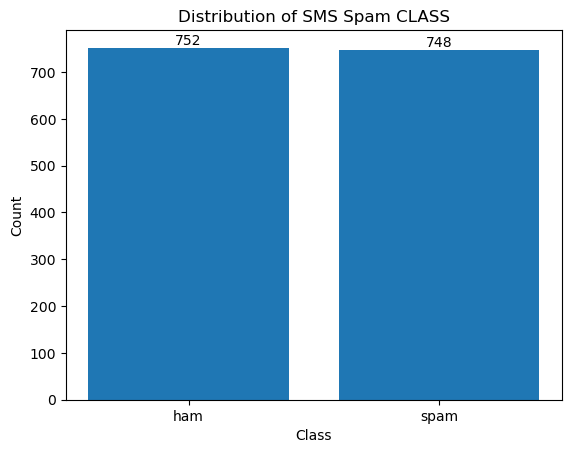

In [111]:
# Create a barplot to visualise number of spam/ham messages in the dataset
plt.bar(data['CLASS'].value_counts().index, data['CLASS'].value_counts().values)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of SMS Spam CLASS')

# Add exact numbers for each class
for i, count in enumerate(data['CLASS'].value_counts().values):
    plt.text(i, count, str(count), ha='center', va='bottom')


# Show the plot
plt.show()

From the barchart above it is evident that the dataset contains an equal distribution of spam and ham messages, which is advantageous because it eliminates the need for stratification based on the target variable when dividing the dataset into training and testing sets.

## 2. Train a machine learning model using TensorFlow

### 2.1. Creating Text Representations

Text data needs to be converted to numeric representations before they can be used to train deep learning models. The Spam classification feature data is converted to TF-IDF vectors and the target variable is converted to one-hot encoding.

In [112]:
# Create an instance of WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

In [113]:
#Custom tokenizer to remove stopwords and use lemmatization
def customtokenize(str):
    #Split string as tokens
    tokens=nltk.word_tokenize(str)
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

In [114]:
#Separate feature and target data
spam_classes_raw = data["CLASS"]
spam_messages = data["SMS"]

In [115]:
#Build a TF-IDF Vectorizer model
vectorizer = TfidfVectorizer(tokenizer=customtokenize)

#Transform feature input to TF-IDF
tfidf=vectorizer.fit_transform(spam_messages)

#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

In [116]:
#Build a label encoder for target variable to convert strings to numeric values.
label_encoder = preprocessing.LabelEncoder()
spam_classes = label_encoder.fit_transform(spam_classes_raw)

#Convert target to one-hot encoding vector
spam_classes = tf.keras.utils.to_categorical(spam_classes,2)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)

X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, spam_classes, test_size=0.10)

TF-IDF Matrix Shape :  (1500, 4569)
One-hot Encoding Shape :  (1500, 2)


The TF-IDF matrix, which represents a collection of samples using the TF-IDF numerical representation, has a shape of (1500, 4569). In this context, "1500" refers to the number of samples (SMS messages) in the collection, and "4569" represents the total number of unique terms or features extracted from those documents. Each message is represented as a row in the matrix, and each unique term is represented as a column.

The target variable CLASS has been one-hot-encoded, and the resulting one-hot encoded matrix has a shape of (1500, 2). In one-hot encoding, categorical variables are represented as binary vectors where each category is represented by a separate binary feature. In this case, there are 2 categories in the dataset (spam/ham). The one-hot encoded matrix has 1500 rows, indicating that there are 1500 samples (SMS messages) in the dataset. Each message is represented by a binary vector of length 2, where one element is 1 and the rest are 0, indicating the presence or absence of a specific category.

### 2.2. Create a deep learning model

In [139]:
#Setup Hyper Parameters for building the model
NB_CLASSES=2
N_HIDDEN=32

# Build a sequential model
model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(N_HIDDEN,
                             input_shape=(X_train.shape[1],),
                              name='Hidden-Layer-1',
                              activation='relu'))

model.add(keras.layers.Dense(N_HIDDEN,
                              name='Hidden-Layer-2',
                              activation='relu'))

model.add(keras.layers.Dense(NB_CLASSES,
                             name='Output-Layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy',#'precision', 
                                                        #'recall', 
                                                        #'f1', 
                                                        'AUC'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden-Layer-1 (Dense)       (None, 32)                146240    
_________________________________________________________________
Hidden-Layer-2 (Dense)       (None, 32)                1056      
_________________________________________________________________
Output-Layer (Dense)         (None, 2)                 66        
Total params: 147,362
Trainable params: 147,362
Non-trainable params: 0
_________________________________________________________________


The model used is a sequential neural network with three layers: two hidden layers and one output layer. The hidden layers have 32 units each. The total number of parameters in the model is 147,362, and all of them are trainable.

### 2.3. Train the model


Training Progress:
------------------------------------
Epoch 1/10
5/5 [==============================] - 0s 79ms/step - loss: 0.6830 - accuracy: 0.6435 - auc: 0.7370 - val_loss: 0.6562 - val_accuracy: 0.9148 - val_auc: 0.9723
Epoch 2/10
5/5 [==============================] - 0s 9ms/step - loss: 0.6306 - accuracy: 0.9546 - auc: 0.9898 - val_loss: 0.6047 - val_accuracy: 0.9593 - val_auc: 0.9882
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.5638 - accuracy: 0.9787 - auc: 0.9974 - val_loss: 0.5480 - val_accuracy: 0.9593 - val_auc: 0.9907
Epoch 4/10
5/5 [==============================] - 0s 11ms/step - loss: 0.4949 - accuracy: 0.9806 - auc: 0.9988 - val_loss: 0.4935 - val_accuracy: 0.9704 - val_auc: 0.9940
Epoch 5/10
5/5 [==============================] - 0s 7ms/step - loss: 0.4281 - accuracy: 0.9843 - auc: 0.9993 - val_loss: 0.4396 - val_accuracy: 0.9593 - val_auc: 0.9942
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 0.3663 - accuracy: 0

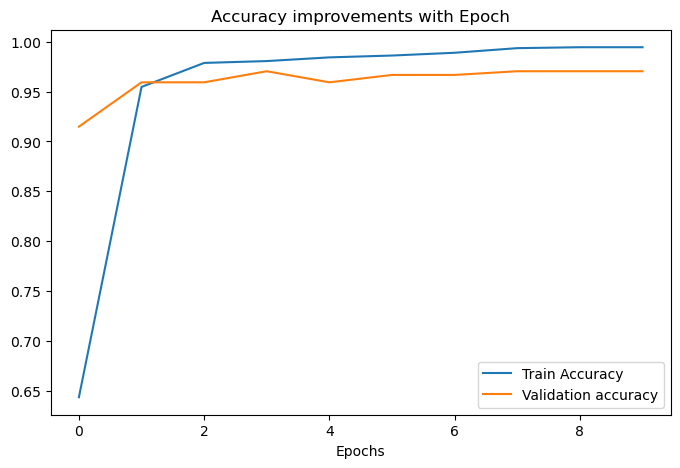

In [140]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=256
EPOCHS=10
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")

pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5), )
pd.DataFrame(history.history)["val_accuracy"].plot(figsize=(8, 5),)
plt.title("Accuracy improvements with Epoch")
plt.xlabel("Epochs")
plt.legend(['Train Accuracy', 'Validation accuracy'])
plt.show()

The model was trained for 10 epochs. During training, the loss decreased gradually, indicating that the model was learning. The accuracy increased consistently, reaching 97.04% at the end of training. The AUC (Area Under the Curve) metric also improved over time, indicating that the model's performance in distinguishing between classes improved. The validation results showed similar trends, with high accuracy and AUC values, demonstrating good generalization of the model to unseen data.

### 2.3. Evaluate the model's performace against the Test Dataset

In [142]:
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)


Evaluation against Test Dataset :
------------------------------------
5/5 [==============================] - 0s 2ms/step - loss: 0.2430 - accuracy: 0.9733 - auc: 0.9857


[0.24299980700016022, 0.9733333587646484, 0.9856888651847839]

The model was evaluated against a test dataset, achieving a loss of 0.2430, an accuracy of 97.33%, and an AUC (Area Under the Curve) of 98.57%. This mans that the model sucessfuly predicts the correct class for unseen (test) data in 97% of the cases.

### 2.4. Predicting SMS messages

Predict class for SMS messages outside the initial dataset.

In [143]:
input = ["FREE entry to a fun contest",
         "Yup I will come over"]

#Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(input).toarray()

#Predict using model
prediction=np.argmax( model.predict(predict_tfidf), axis=1 )

#Print prediction classes
print("Prediction Input:" , input)
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(2, 4569)
Prediction Input: ['FREE entry to a fun contest', 'Yup I will come over']
Prediction Classes are  ['spam' 'ham']
